In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


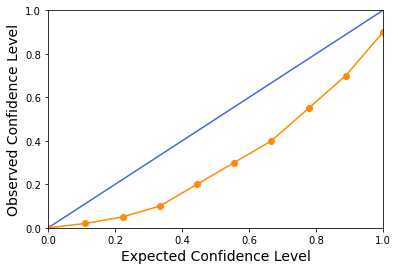

In [2]:
from training.regresssion import plot_calibration

class FakeResults:
    pass
results = FakeResults()
results.quantile_ps = torch.linspace(0, 1, 10)

# Underconfident
#results.observed_cdf = torch.tensor([0.05, 0.3, 0.5, 0.65, 0.75, 0.82, 0.88, 0.94, 0.98, 1])

# Overconfident
results.observed_cdf = torch.tensor([0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.55, 0.7, 0.9])

# Overconfident Quantile
#results.observed_cdf = torch.tensor([0.8, 0.77, 0.72, 0.65, 0.55, 0.45, 0.4, 0.35, 0.34, 0.33])

plot_calibration(None, results, plt.subplot(), include_text=False)
plt.savefig("results/figs/overconfident_regression.pdf")

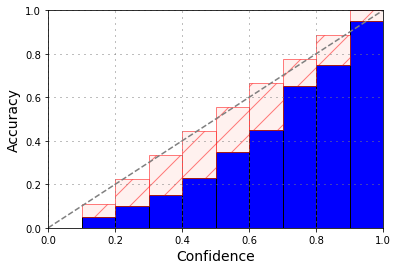

In [24]:
from training.calibration import reliability_diagram

# Underconfident
accuracies = torch.tensor([0, 0.05, 0.1, 0.15, 0.23, 0.35, 0.45, 0.65, 0.75, 0.95])

# Overconfident
#accuracies = torch.tensor([0.05, 0.2, 0.35, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1])

reliability_diagram(10, accuracies, torch.linspace(0, 1, 10), plt.subplot(), False, False, False, False, False)
plt.savefig("results/figs/overconfident_classification.pdf")

In [105]:
from training.spline import interpolate
from experiments.toy_regression import gap_datasets, NOISE, plot_grid
from scipy.interpolate import CubicSpline
from training.regresssion import normalize, denormalize

device = torch.device("cpu")

dataset, dataloader, testset = gap_datasets(device)

def create_splines(outside_std, gap_std):
    def spline_infer(x, samples):
        x = denormalize(x, dataset.x_mean, dataset.x_std)

        t = torch.cat((torch.linspace(0, 0.13, 10), torch.linspace(0.4, 0.55, 10)))
        output = []
        for _ in range(samples):
            xs = torch.cat((t, torch.tensor([-0.4, 0.9, 0.23])))
            left_y = torch.normal(torch.tensor(-1.0), torch.tensor(outside_std))
            right_y = torch.normal(torch.tensor(1.0), torch.tensor(outside_std))
            gap_y = torch.normal(torch.tensor(0.6), torch.tensor(gap_std))
            ys = torch.cat((dataset.eval(t, torch.tensor(0)), torch.tensor([left_y, right_y, gap_y])))
            xs, sort_indices = torch.sort(xs)
            ys = ys[sort_indices]
            spline = CubicSpline(xs, ys, bc_type="natural")
            output.append(torch.from_numpy(spline(x)))

        output = torch.stack(output)
        output = normalize(output, dataset.y_mean, dataset.y_std)
        return torch.stack((output, NOISE.expand(output.shape) / dataset.y_std), dim=-1)

    return spline_infer
    
#dataset.plot_predictions(-0.3, 0.8, create_splines(0.5, 0.2), 100, plt.subplot(), plot_ground_truth=True, alpha=0.3)
#plt.scatter([-0.4, 0.9, 0.23], [-1.0, 1.0, 0.6])

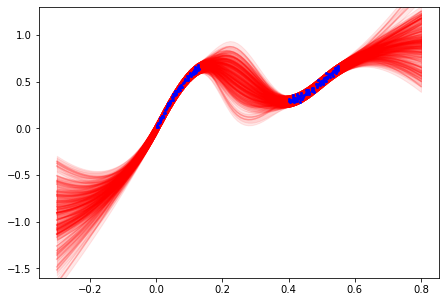

In [117]:
dataset.plot_predictions(-0.3, 0.8, create_splines(0.5, 0.15), 50, plt.subplot(), plot_ground_truth=False, alpha=0.3)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/good_epistemic.pdf")

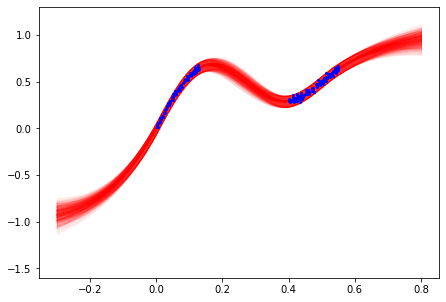

In [115]:
dataset.plot_predictions(-0.3, 0.8, create_splines(0.1, 0.03), 50, plt.subplot(), plot_ground_truth=False, alpha=0.1)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/narrow_epistemic.pdf")

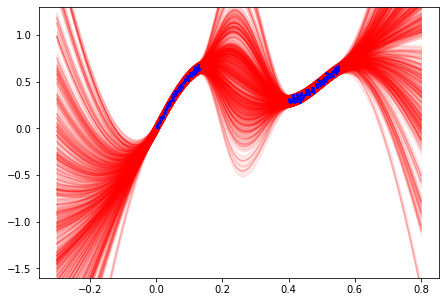

In [116]:
dataset.plot_predictions(-0.3, 0.8, create_splines(2.0, 0.4), 100, plt.subplot(), plot_ground_truth=False, alpha=0.3)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/wide_epistemic.pdf")

In [6]:
import os
from experiments.uci.results import UCIResults

all_results = {}

os.chdir("c:/Uni/Bachelor/results/UCI_GAP/results")
for method in os.listdir("."):
    if not os.path.isdir(method):
        continue
    print(method)
    os.chdir(method)
    
    for dataset in os.listdir("."):
        if not os.path.isdir(dataset):
            continue
        name = dataset.split('__')[1][1:]
        if name not in all_results:
            all_results[name] = {}
        print(f"  {name}")

        results = []
        for file in os.listdir(dataset + "/log"):
            if not file.endswith(".pyc"):
                continue
            results.append(UCIResults.load(dataset + "/log/" + file))
        all_results[name][method] = results
    os.chdir("..")

Ensemble-5
  concrete
  energy
  housing
  power
  wine
  yacht
LRVI-10
  concrete
  energy
  housing
  power
  wine
  yacht
LRVI-2
  concrete
  energy
  housing
  power
  wine
  yacht
LRVI-5
  concrete
  energy
  housing
  power
  wine
  yacht
MAP
  concrete
  energy
  housing
  power
  wine
  yacht
MCDropout
  concrete
  energy
  housing
  power
  wine
  yacht
MFVI
  concrete
  energy
  housing
  power
  wine
  yacht
Multi-MFVI-5
  concrete
  energy
  housing
  power
  wine
  yacht
MultiMCDropout
  concrete
  energy
  housing
  power
  wine
  yacht
MultiSWAG
  concrete
  energy
  housing
  power
  wine
  yacht
SGLD
  concrete
  energy
  housing
  power
  wine
  yacht
slurmlog
SWAG
  concrete
  energy
  housing
  power
  wine
  yacht


In [7]:
import numpy as np

def print_method(method, method_results):
    times = []
    lml = []
    mean_mse = []
    mse_of_means = []
    qce = []
    for rep in method_results:
        times.append(rep.time)
        lml.append(rep.results.average_lml)
        mean_mse.append(rep.results.mean_mse)
        mse_of_means.append(rep.results.mse_of_means)
        qce.append(rep.results.qce)
    times = torch.tensor(times)
    lml = torch.tensor(lml)
    mean_mse = torch.tensor(mean_mse)
    mse_of_means = torch.tensor(mse_of_means)
    qce = torch.tensor(qce)

    print((f"            & {method}"
        f" & ${lml.mean():.2f} \\pm {lml.std() / np.sqrt(len(lml)):.2f}$"
        #f" & ${mean_mse.mean():.2f} \\pm {mean_mse.std() / np.sqrt(len(mean_mse)):.2f}$"
        f" & ${mse_of_means.mean():.2f} \\pm {mse_of_means.std() / np.sqrt(len(mse_of_means)):.2f}$"
        f" & ${qce.mean():.2f} \\pm {qce.std() / np.sqrt(len(qce)):.2f}$"
        #f" & ${times.mean():.2f} \\pm {times.std() / np.sqrt(len(times)):.2f}$"
        " \\\\"
    ))

def print_dataset(dataset, dataset_results):
    print("        \\midrule")
    print("        \\multirow{" + str(len(dataset_results)) + "}{*}{" + dataset + "}")
    print_method("MAP", dataset_results["MAP"])
    print_method("Ensemble-5", dataset_results["Ensemble-5"])
    print_method("MCD", dataset_results["MCDropout"])
    print_method("MultiMCD-5", dataset_results["MultiMCDropout"])
    print_method("SWAG", dataset_results["SWAG"])
    print_method("MultiSWAG-5", dataset_results["MultiSWAG"])
    print_method("MFVI", dataset_results["MFVI"])
    print_method("MultiMFVI-5", dataset_results["Multi-MFVI-5"])
    print_method("LRVI-2", dataset_results["LRVI-2"])
    print_method("LRVI-5", dataset_results["LRVI-5"])
    print_method("LRVI-10", dataset_results["LRVI-10"])
    print_method("SLGD", dataset_results["SGLD"])

print_dataset("Housing", all_results["housing"])
print_dataset("Concrete", all_results["concrete"])
print_dataset("Energy", all_results["energy"])
print_dataset("Wine", all_results["wine"])
print_dataset("Yacht", all_results["yacht"])
print_dataset("Power", all_results["power"])

        \midrule
        \multirow{12}{*}{Housing}
            & MAP & $-4.23 \pm 0.09$ & $14.69 \pm 0.47$ & $0.17 \pm 0.00$ \\
            & Ensemble-5 & $-3.83 \pm 0.06$ & $12.85 \pm 0.35$ & $0.12 \pm 0.00$ \\
            & MCD & $-2.98 \pm 0.03$ & $12.73 \pm 0.34$ & $0.09 \pm 0.00$ \\
            & MultiMCD-5 & $-2.94 \pm 0.03$ & $12.36 \pm 0.35$ & $0.07 \pm 0.00$ \\
            & SWAG & $-2.93 \pm 0.03$ & $12.96 \pm 0.35$ & $0.09 \pm 0.00$ \\
            & MultiSWAG-5 & $-2.91 \pm 0.02$ & $12.60 \pm 0.31$ & $0.08 \pm 0.00$ \\
            & MFVI & $-2.82 \pm 0.03$ & $12.96 \pm 0.39$ & $0.05 \pm 0.00$ \\
            & MultiMFVI-5 & $-2.79 \pm 0.03$ & $12.46 \pm 0.37$ & $0.04 \pm 0.00$ \\
            & LRVI-2 & $-2.78 \pm 0.03$ & $12.71 \pm 0.40$ & $0.05 \pm 0.00$ \\
            & LRVI-5 & $-2.76 \pm 0.03$ & $13.22 \pm 0.46$ & $0.05 \pm 0.00$ \\
            & LRVI-10 & $-2.77 \pm 0.03$ & $12.70 \pm 0.50$ & $0.04 \pm 0.00$ \\
            & SLGD & $-2.72 \pm 0.01$ & $16.73 \pm 0.59$ & $

Ensemble-5


/home/flo/VariationalBayesianDL/training/calibration.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_ax.set_xticklabels(self.bin_counts)


MAP


/home/flo/VariationalBayesianDL/training/calibration.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_ax.set_xticklabels(self.bin_counts)


MultiSWAG


/home/flo/VariationalBayesianDL/training/calibration.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_ax.set_xticklabels(self.bin_counts)


SWAG


/home/flo/VariationalBayesianDL/training/calibration.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_ax.set_xticklabels(self.bin_counts)


        MAP & $0.74 \pm 0.00$ & $-0.76 \pm 0.01$ & $0.01\textrm{O} \pm 0.00$ & $nan \pm nan$ & $nan \pm nan$ & $nan\textrm{O} \pm nan$ \\
        Ensemble-5 & $0.80 \pm 0.00$ & $-0.76 \pm 0.01$ & $0.13\textrm{U} \pm 0.01$ & $nan \pm nan$ & $nan \pm nan$ & $nan\textrm{O} \pm nan$ \\
        SWAG & $0.75 \pm 0.00$ & $-0.86 \pm 0.01$ & $0.11\textrm{U} \pm 0.00$ & $nan \pm nan$ & $nan \pm nan$ & $nan\textrm{O} \pm nan$ \\
        MultiSWAG-5 & $0.78 \pm 0.00$ & $-0.87 \pm 0.01$ & $0.19\textrm{U} \pm 0.01$ & $nan \pm nan$ & $nan \pm nan$ & $nan\textrm{O} \pm nan$ \\


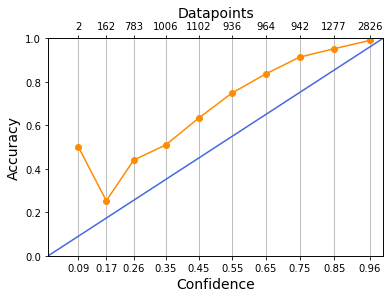

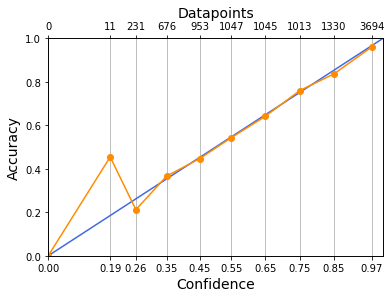

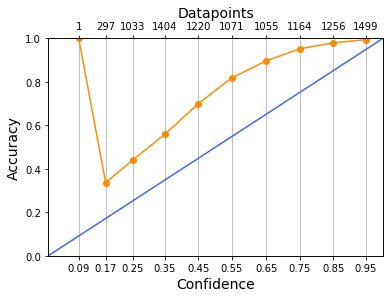

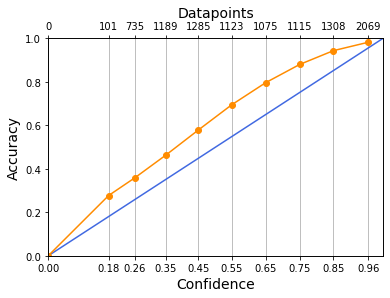

In [3]:
import os
from experiments.fmnist.results import FMNISTResults
import numpy as np
import torch
import matplotlib.pyplot as plt

all_results = {}

in_path = "/mnt/c/Uni/Bachelor/results/CIFAR10/results"
out_path = "/home/flo/VariationalBayesianDL/results/CIFAR10"

os.chdir(in_path)
for method in os.listdir("."):
    if not os.path.isdir(method) or method == "slurmlog":
        continue
    print(method)
    
    normal_results = []
    corrupted_results = []
    for file in os.listdir(method + "/log"):
        if not file.endswith(".pyc"):
            continue
        if file.endswith("_normal.pyc"):
            normal_results.append(FMNISTResults.load(method + "/log/" + file))
        elif file.endswith("_corrupted.pyc"):
            corrupted_results.append(FMNISTResults.load(method + "/log/" + file))
    all_results[method] = (normal_results, corrupted_results)

    if len(normal_results) > 0:
        fig, ax = plt.subplots()
        normal_results[0].calibration_results.plot_reliability(ax, include_text=False)
        fig.savefig(f"{out_path}/plots/reliability/{method}_normal.pdf")

    if len(corrupted_results) > 0:
        fig, ax = plt.subplots()
        corrupted_results[0].calibration_results.plot_reliability(ax, include_text=False)
        fig.savefig(f"{out_path}/plots/reliability/{method}_corrupted.pdf")

def print_method(method, method_results):
    times = []

    normal_acc = []
    normal_ece = []
    normal_sece = []
    normal_lml = []
    for rep in method_results[0]:
        times.append(rep.time)
        normal_acc.append(rep.accuracy)
        normal_ece.append(rep.calibration_results.ece)
        normal_sece.append(rep.calibration_results.signed_ece)
        normal_lml.append(rep.log_likelihood)
    normal_acc = torch.tensor(normal_acc)
    normal_ece = torch.tensor(normal_ece)
    normal_sece = torch.tensor(normal_sece)
    normal_lml = torch.tensor(normal_lml)

    corr_acc = []
    corr_ece = []
    corr_sece = []
    corr_lml = []
    for rep in method_results[1]:
        times.append(rep.time)
        corr_acc.append(rep.accuracy)
        corr_ece.append(rep.calibration_results.ece)
        corr_sece.append(rep.calibration_results.signed_ece)
        corr_lml.append(rep.log_likelihood)
    corr_acc = torch.tensor(corr_acc)
    corr_ece = torch.tensor(corr_ece)
    corr_sece = torch.tensor(corr_sece)
    corr_lml = torch.tensor(corr_lml)

    times = torch.tensor(times)

    print((f"        {method}"
        f" & ${normal_acc.mean():.2f} \\pm {normal_acc.std() / np.sqrt(len(normal_acc)):.2f}$"
        f" & ${normal_lml.mean():.2f} \\pm {normal_lml.std() / np.sqrt(len(normal_lml)):.2f}$"
        f" & ${normal_ece.mean():.2f}\\textrm{{{'U' if normal_sece.mean() > 0 else 'O'}}} \\pm {normal_ece.std() / np.sqrt(len(normal_ece)):.2f}$"
        f" & ${corr_acc.mean():.2f} \\pm {corr_acc.std() / np.sqrt(len(corr_acc)):.2f}$"
        f" & ${corr_lml.mean():.2f} \\pm {corr_lml.std() / np.sqrt(len(corr_lml)):.2f}$"
        f" & ${corr_ece.mean():.2f}\\textrm{{{'U' if corr_sece.mean() > 0 else 'O'}}} \\pm {corr_ece.std() / np.sqrt(len(corr_ece)):.2f}$"
        #f" & ${times.mean():.2f} \\pm {times.std() / np.sqrt(len(times)):.2f}$"
        " \\\\"
    ))

print_method("MAP", all_results["MAP"])
print_method("Ensemble-5", all_results["Ensemble-5"])
#print_method("MCD", all_results["MCDropout"])
#print_method("MultiMCD-5", all_results["MultiMCDropout"])
print_method("SWAG", all_results["SWAG"])
print_method("MultiSWAG-5", all_results["MultiSWAG"])
#print_method("VOGN", all_results["VOGN"])
#print_method("MultiVOGN", all_results["MultiVOGN"])
#print_method("MFVI", all_results["MFVI"])
#print_method("MultiMFVI-5", all_results["MultiMFVI-5"])

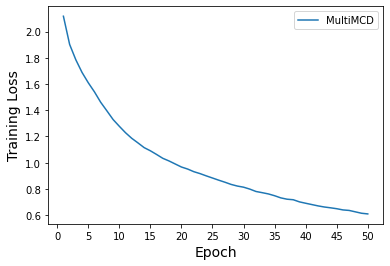

In [5]:
from training.util import plot_losses
from experiments.fmnist.results import FMNISTResults
import matplotlib.pyplot as plt

plot_losses("MultiMCD", FMNISTResults.load("/mnt/c/Uni/Bachelor/results/CIFAR10/results/SWAG/log/rep_00results_normal.pyc").losses, plt.subplot())

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
from experiments.base.shifts import WeatherShiftsDataset

dataset = WeatherShiftsDataset("/mnt/d/Uni/Bachelorarbeit/linux/data/")

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [3]:
batch_size = 512
trainloader = dataset.trainloader(batch_size, small=True)
valloader = dataset.in_valloader(1000)

In [11]:
def validate(model):
    with torch.no_grad():
        loss = 0
        for data, target in valloader:
            output = model(data, 100).mean(dim=0)
            loss += nll_loss(output, target).detach().item()
        return loss / len(valloader)

In [12]:
import torch
from training.util import nll_loss, adam, sgd, EarlyStopper
from training.pp import MAP

init_std = torch.tensor(0.1)

es = EarlyStopper(validate, 1, 1e-5, 5)

layers = [
    ("fc", (123, 256)),
    ("relu", ()),
    ("fc", (256, 512)),
    ("relu", ()),
    ("fc", (512, 256)),
    ("relu", ()),
    ("fc", (256, 128)),
    ("relu", ()),
    ("fc", (128, 1)),
    ("gauss", (init_std, True)),
]

model = MAP(layers)
model.train_model(50, nll_loss, adam(3e-3), trainloader, batch_size, device, early_stopping=es)

Epoch 0: loss 1.6449122428894043
Epoch 1: loss -0.9806888699531555
Epoch 2: loss -1.0502270460128784
Epoch 3: loss -1.0719650983810425
Epoch 4: loss -1.0937596559524536
Epoch 5: loss -1.1068482398986816
Epoch 6: loss -1.1154747009277344
Epoch 7: loss -1.1262705326080322
Epoch 8: loss -1.133398175239563
Epoch 9: loss -1.1430981159210205
Epoch 10: loss -1.148022174835205
Epoch 11: loss -1.1556353569030762
Epoch 12: loss -1.156590223312378
Epoch 13: loss -1.166551947593689
Epoch 14: loss -1.1677230596542358
Epoch 15: loss -1.1703925132751465
Epoch 16: loss -1.1853107213974
Epoch 17: loss -1.1911630630493164
Epoch 18: loss -1.1974952220916748
Epoch 19: loss -1.2034538984298706
Epoch 20: loss -1.1895854473114014
Epoch 21: loss -1.2058677673339844
Epoch 22: loss -1.2181378602981567
Epoch 23: loss -1.2126851081848145
Epoch 24: loss -1.2364461421966553
Epoch 25: loss -1.2464830875396729
Epoch 26: loss -1.2756431102752686
Epoch 27: loss -1.262280821800232
Epoch 28: loss -1.2800506353378296
Epoc

In [6]:
model.model[-1].var.sqrt()

tensor(0.1254, grad_fn=<SqrtBackward0>)

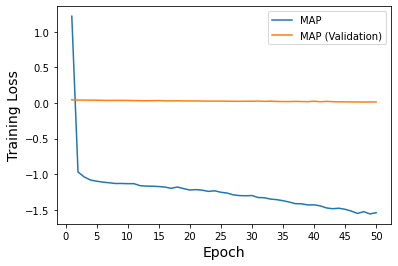

In [7]:
import matplotlib.pyplot as plt
from training.util import plot_losses

plot_losses("MAP", model.all_losses(), plt.subplot(), val_losses=es.losses)

In [8]:
in_testloader = dataset.in_testloader(batch_size)
out_testloader = dataset.out_testloader(batch_size)

In [10]:
from training.regresssion import RegressionResults

res = RegressionResults(in_testloader, "MAP", model.infer, 10, device, target_mean=dataset.target_mean, target_std=dataset.target_std)
print(res.mse_of_means)
print(res.qce)

tensor(5.3554)
tensor(0.2014)


In [109]:
from training.regresssion import RegressionResults

res = RegressionResults(out_testloader, "MAP", model.infer, 10, device, target_mean=dataset.target_mean, target_std=dataset.target_std)
print(res.mse_of_means)
print(res.qce)

tensor(6.5050)
tensor(0.1970)
